In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.core import *

[17:00:41] lib:INFO: Default saving mode set to do_save False
[17:00:41] lib:INFO: Making sure output folder is defined and exists in the location where the library is imported: ./test


In [3]:
pd.DataFrame(check_dep_versions())

,Python,tqdm,numpy,pandas,scipy,statsmodels,matplotlib,seaborn,datashader,ultraplot,scikit-learn,cooler,cooltools,bioframe,fontanka,pybbi
installed,3.12.12,4.67.1,2.3.5,2.3.3,1.16.3,0.14.5,3.10.8,0.13.2,0.18.2,1.66.0,1.7.2,0.10.4,0.7.1,0.8.0,0.2,0.4.2
expected,3.12,None,2.3.5,2.3.3,1.16.3,0.14.5,3.10.8,0.13.2,0.18.2,1.66.0,None,0.10.4,0.7.1,0.8.0,0.2,0.4.2
op,==,None,>=,>=,>=,>=,>=,>=,>=,>=,None,>=,>=,>=,>=,>=
status,installed,installed,ok,ok,ok,ok,ok,ok,ok,ok,installed,ok,ok,ok,ok,ok


In [3]:
from lib.read_data_basic import *

[10:15:26] lib:INFO: Loading chromsizes for danRer11 (reduced)
[10:15:26] lib:INFO: Loading chromosome arm sizes table
[10:15:26] lib:INFO: Loading differential fountain calls (mutant vs WT)
[10:15:26] lib:INFO: Collecting cooler paths for danRer11 datasets
[10:15:26] lib:INFO: Opening base cooler at /home/agalicina/DANIO/HIC/data_danrer11/distiller/results_danrer11/coolers_library_group/WT.danrer11-reduced.mapq_30.1000.mcool::/resolutions/10000
[10:15:26] lib:INFO: Extracting bins table from cooler
[10:15:26] lib:INFO: Loading clean bins with 50 Kb buffer from unmappable regions
[10:15:26] lib:INFO: Loading CTCF motif calls from JASPAR track
[10:15:26] lib:INFO: Loading ATAC-seq peaks (ATAC-Seq_4.5h_DCD019097DT) and annotating CTCF motifs
[10:15:26] lib:INFO: Loading ATAC-seq peaks (ATAC-Seq_12h_DCD019077DT) and annotating CTCF motifs
[10:15:27] lib:INFO: Loading boundary calls (all strengths)
[10:15:27] lib:INFO: Loading strong boundary calls
Number of different types of boundaries: 

In [4]:
# # Set up saving mode
do_save = True
output_folder = "./results_2025-12-03_AxG_general-chromatin"
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# General chromatin properties

### + PCA based on SCC for all *Danio rerio* Hi-C (Fig. 1f)

In [5]:
section_start()

✅ Section started


In [6]:
from sklearn.decomposition import PCA

Load SCC score on all available Hi-C data:

In [7]:
df_scc = pd.read_csv(
    "/home/agalicina/DANIO/HIC/WD_2021_paper/01_scc/results/pairwise_danio.100000.txt",
    sep=",",
    header=None,
)
df_scc = df_scc[df_scc[0] == "SCC"]

df_scc.columns = ["coef_index", "resolution", "file1", "file2", "value"]

In [8]:
df_scc.loc[:, "title1"] = df_scc.file1.apply(
    lambda x: x.split("/")[-1].split(".danrer11-reduced")[0]
)
df_scc.loc[:, "title2"] = df_scc.file2.apply(
    lambda x: x.split("/")[-1].split(".danrer11-reduced")[0]
)

df_scc.loc[:, "chrom1"] = df_scc.file1.apply(lambda x: x.split("/")[-1].split(".")[-3])
df_scc.loc[:, "chrom2"] = df_scc.file2.apply(lambda x: x.split("/")[-1].split(".")[-3])

lst = ["unknown1", "unknown2", "unknown3", "unknown4", "unknown5", "unknown6"]
df_scc = df_scc.query(f"title1 not in {lst} and title2 not in {lst}").reset_index(
    drop=True
)

del lst

In [9]:
cols = [
    "sperm",
    "Wike2021_WT_ZF_Sperm",
    "Wike2021_WT_ZF_Embryos_2.25hpf_ED",
    "Wild-Type_2.75",
    "embryos_4hpf",
    "Wike2021_WT_ZF_Embryos_4hpf",
    "WT",
    "Wild-Type_5.3",
    "Wike2021_WT_ZF_Embryos_5.3hpf",
    "embryos_8hpf",
    "Wild-Type_11",
    "Wike2021_WT_ZF_Embryos_24hpf",
    "embryos_24hpf",
    "Wild-Type_25",
    "MZspg_2.75",
    "MZnanog_2.75",
    "MZspg_5.3",
    "MZsox19b_5.3",
    "MZnanog_5.3",
    "PS",
    "SN",
    "NP",
    "TR",
]

In [10]:
df_x = (
    df_scc.groupby(["title1", "title2"])["value"]
    .mean()
    .reset_index()
    .pivot(index="title1", columns="title2", values="value")
)
df_x = df_x.loc[cols, cols]
x = 1 - np.nanmean(np.dstack([df_x, df_x.T]), axis=2)

In [11]:
pca = PCA(n_components=4)
pca.fit(x)

print(100 * pca.explained_variance_ratio_)

print(pca.singular_values_)

[47.68359164 31.41648425  9.94586494  6.1771768 ]
[1.31735012 1.06929005 0.60164182 0.47414563]


In [12]:
np.cumsum(pca.explained_variance_ratio_)

array([0.47683592, 0.79100076, 0.89045941, 0.95223118])

In [13]:
# Note that to reproduce the plot from the paper you may need to flip the sign of components:
df_pca = pd.DataFrame(
    {
        "PC1": -pca.components_[0],
        "PC2": pca.components_[1],
        "PC3": pca.components_[2],
        "PC4": pca.components_[3],
        "title": cols,
    }
)

In [14]:
df_pca["condition"] = df_pca["title"].apply(
    lambda x: (
        "rm"
        if x.split("_")[-1] in ["LD", "FLAV", "SGC", "DMSO"] or "2.3" in x
        else (
            "WT_Wike"
            if "Wike" in x
            else (
                "WT_Kaaij"
                if "embryo" in x
                else (
                    "WT"
                    if "WT" in x
                    else "WT" if "Wild-Type" in x else "WT" if "sperm" in x else "mut"
                )
            )
        )
    )
)

df_pca["mutant"] = df_pca["title"].apply(
    lambda x: (
        "rm"
        if x.split("_")[-1] in ["LD", "FLAV", "SGC", "DMSO"] or "2.3" in x
        else (
            "WT_Wike"
            if "Wike" in x
            else (
                "WT_Kaaij"
                if "embryo" in x
                else (
                    "WT"
                    if "WT" in x
                    else (
                        "WT"
                        if "Wild-Type" in x
                        else (
                            "WT"
                            if "sperm" in x
                            else (
                                x.split("_")[0][:-1]
                                if len(x.split("_")[0]) == 3
                                else x.split("_")[0]
                            )
                        )
                    )
                )
            )
        )
    )
)

df_pca["time"] = df_pca["title"].apply(
    lambda x: (
        2.75
        if "2.75" in x
        else (
            2.25
            if "2.25" in x
            else (
                2.3
                if "2.3" in x
                else (
                    5.3
                    if "5.3" in x
                    else (
                        8
                        if "8hpf" in x
                        else (
                            11
                            if "11" in x
                            else (
                                24
                                if "24" in x
                                else (
                                    25
                                    if "25" in x
                                    else 4 if "4hpf" in x else 0 if "perm" in x else 5.3
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [15]:
list_toplot = ["WT_Wike", "WT_Kaaij", "WT"]

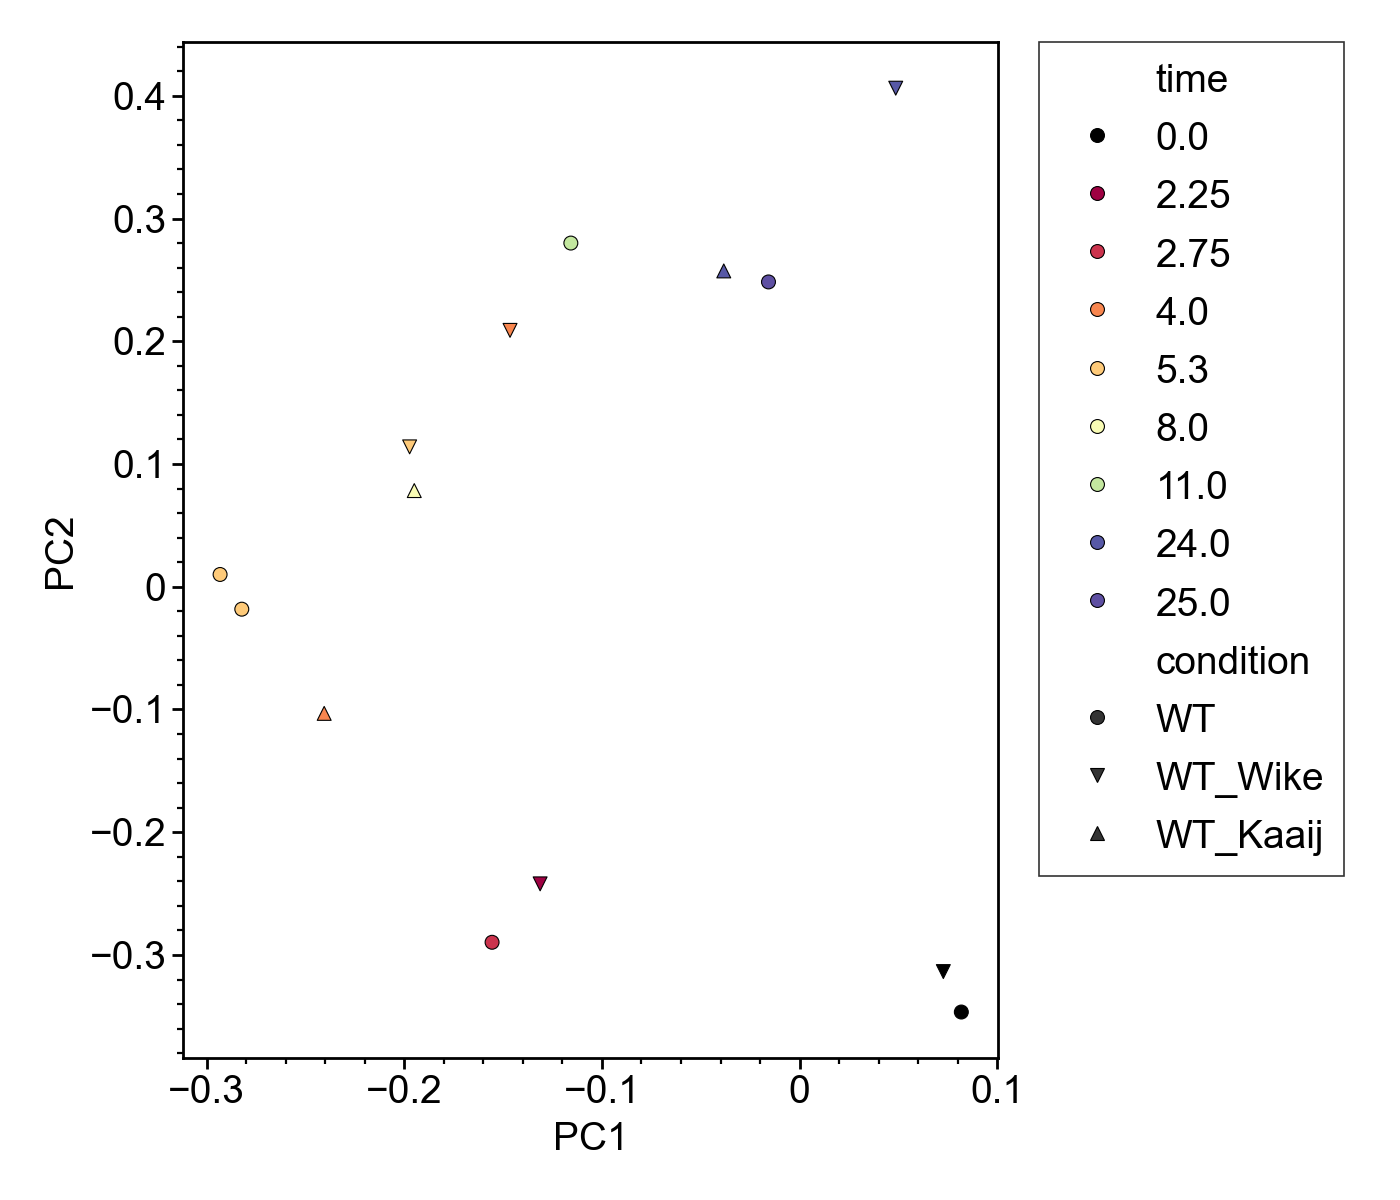

In [16]:
plt.figure(figsize=[7, 6])
sns.scatterplot(
    data=df_pca.query(f"mutant in {list_toplot}"),
    x="PC1",
    y="PC2",
    hue="time",
    style="condition",
    markers={"mut": "X", "WT": "o", "WT_Wike": "v", "WT_Kaaij": "^", "RT": "*"},
    hue_norm=mpl.colors.LogNorm(),
    palette=sns.palettes.color_palette("Spectral", 9, as_cmap=True),
    s=25,
    edgecolor="black",
    alpha=1.0,
    legend="full",
)

plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()

if do_save:
    prefix = f"{output_folder}/Fig1F.PCA"
    plt.savefig(f"{prefix}.png")
    plt.savefig(f"{prefix}.pdf")

In [17]:
# Save the data:
df_output = df_pca.query(f"mutant in {list_toplot}").loc[
    :, ["PC1", "PC2", "title", "condition", "mutant", "time"]
]

if do_save:
    prefix = f"{output_folder}/Fig1F.PCA"
    df_output.to_csv(f"{prefix}.source.csv")

In [18]:
section_flush()

✅ Section cleaned


### + Joint plot IS and E1 (compartments), Fig. 1f

In [19]:
section_start()

✅ Section started


In [20]:
cols = [
    "Wild-Type_5.3",
    "embryos_8hpf",
    "Wild-Type_2.75",
    "MZnanog_2.75",
    "MZspg_5.3",
    "embryos_4hpf",
    "MZnanog_5.3",
    "Wild-Type_11",
    "sperm",
    "embryos_24hpf",
    "MZspg_2.75",
    "NP",
    "Wild-Type_25",
    "MZsox19b_5.3",
    "YueLab-brain-HiC",
    "SN",
    "TR",
    "embryos_2.3hpf",
    "WT",
    "PS",
    "MZnanog_2.75_2",
    "embryos_2.3hpf_1",
    "TR1",
    "Wike2021_WT_ZF_Embryos_5.3hpf",
    "YueLab-brain-HiC-rep2",
    "Wike2021_WT_ZF_Embryos_2.25hpf_LD",
    "NP2",
    "WT2",
    "embryos_24hpf_3",
    "YueLab-muscle-HiC-rep1",
    "Wild-Type_25_2",
    "MZspg_2.75_2",
    "Wild-Type_5.3_1",
    "Wike2021_WT_ZF_Embryos_4hpf_FLAV",
    "MZnanog_5.3_1",
    "Wild-Type_2.75_2",
    "MZspg_2.75_1",
    "SN2",
    "TR2",
    "MZnanog_2.75_1",
    "Wike2021_WT_ZF_Embryos_24hpf",
    "embryos_4hpf_1",
    "PS2",
    "WT1",
    "embryos_24hpf_1",
    "MZspg_5.3_1",
    "Wild-Type_25_1",
    "MZspg_5.3_2",
    "SN1",
    "embryos_24hpf_2",
    "Wike2021_WT_ZF_Embryos_4hpf",
    "YueLab-brain-HiC-rep1",
    "NP1",
    "MZnanog_5.3_2",
    "embryos_8hpf_1",
    "sperm_2",
    "Wild-Type_5.3_2",
    "MZsox19b_5.3_1",
    "embryos_8hpf_3",
    "embryos_2.3hpf_2",
    "Wike2021_WT_ZF_Embryos_4hpf_SGC",
    "embryos_8hpf_2",
    "Wike2021_WT_ZF_Embryos_2.25hpf_ED",
    "embryos_4hpf_2",
    "Wild-Type_11_2",
    "sperm_1",
    "Wike2021_WT_ZF_Embryos_4hpf_DMSO",
    "Wike2021_WT_ZF_Sperm",
    "MZsox19b_5.3_2",
    "Wild-Type_2.75_1",
    "Wild-Type_11_1",
    "PS1",
]

In [21]:
reference_source = "Wild-Type_25"
resolution_jointplot_e1 = 50_000

df_saddle_strength = pd.read_csv(
    f"/home/agalicina/DANIO/HIC/WD_2021_paper/03_compartment/results/df_saddle.bychr.by-{reference_source}.{resolution_jointplot_e1}.csv"
)
df_compstrength = (
    df_saddle_strength.replace([np.inf, -np.inf], np.nan)
    .dropna()
    .groupby("label")
    .agg({"score": np.nanmean, "reg": "first", "reference": "first"})
)

del resolution_jointplot_e1, reference_source

In [22]:
reference_source = "Wild-Type_25"
resolution_jointplot_is = 10_000

df_is = {"label": [], "insulation": []}

# Load reference table:
df_is_ref = pd.read_csv(
    f"/home/agalicina/DANIO/HIC/WD_2021_paper/02_insulation/results/insulation.withboundaries.{reference_source}.{resolution_jointplot_is}.csv"
)

# Load insulation for each experiment:
for clr_prefix in tqdm.tqdm(cols):
    try:
        df_is_tmp = pd.read_csv(
            f"/home/agalicina/DANIO/HIC/WD_2021_paper/02_insulation/results/insulation.withboundaries.{clr_prefix}.{resolution_jointplot_is}.csv"
        )

        # Compare with reference:
        df_is_tmp.loc[:, "is_ref_boundary"] = df_is_ref["is_boundary"]
        ins = np.nanmean(
            df_is_tmp.query("is_ref_boundary==True and is_bad_bin==False")[
                "log2_insulation_score_100000"
            ]
        )
        df_is["label"] += [clr_prefix]
        df_is["insulation"] += [ins]

    except Exception as e:
        pass

df_is = pd.DataFrame(df_is)

del resolution_jointplot_is, reference_source, df_is_tmp, ins

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:08<00:00,  8.98it/s]


In [23]:
df_toplot = pd.merge(df_is, df_compstrength, on=["label"])

In [24]:
df_toplot["condition"] = df_toplot["label"].apply(
    lambda x: (
        "rm"
        if x.split("_")[-1] in ["LD", "FLAV", "SGC", "DMSO"] or "2.3" in x
        else (
            "WT_Wike"
            if "Wike" in x
            else (
                "WT_Kaaij"
                if "embryo" in x
                else (
                    "WT"
                    if "WT" in x
                    else "WT" if "Wild-Type" in x else "WT" if "sperm" in x else "mut"
                )
            )
        )
    )
)

df_toplot["mutant"] = df_toplot["label"].apply(
    lambda x: (
        "unused"
        if x.split("_")[-1] in ["LD", "FLAV", "SGC", "DMSO"] or "2.3" in x
        else (
            "WT_Wike"
            if "Wike" in x
            else (
                "WT_Kaaij"
                if "embryo" in x
                else (
                    "WT"
                    if "WT" in x
                    else (
                        "WT"
                        if "Wild-Type" in x
                        else (
                            "WT"
                            if "sperm" in x
                            else (
                                "N"
                                if "MZnanog" in x
                                else (
                                    "S"
                                    if "MZsox19b" in x
                                    else (
                                        "P"
                                        if "MZspg" in x
                                        else (
                                            x.split("_")[0][:-1]
                                            if len(x.split("_")[0]) == 3
                                            else x.split("_")[0]
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

df_toplot["time"] = df_toplot["label"].apply(
    lambda x: (
        2.75
        if "2.75" in x
        else (
            2.25
            if "2.25" in x
            else (
                2.3
                if "2.3" in x
                else (
                    5.3
                    if "5.3" in x
                    else (
                        8
                        if "8hpf" in x
                        else (
                            11
                            if "11" in x
                            else (
                                24
                                if "24" in x
                                else (
                                    25
                                    if "25" in x
                                    else 4 if "4hpf" in x else 0 if "perm" in x else 5.3
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [25]:
list_toplot = ["WT_Wike", "WT_Kaaij", "WT"]

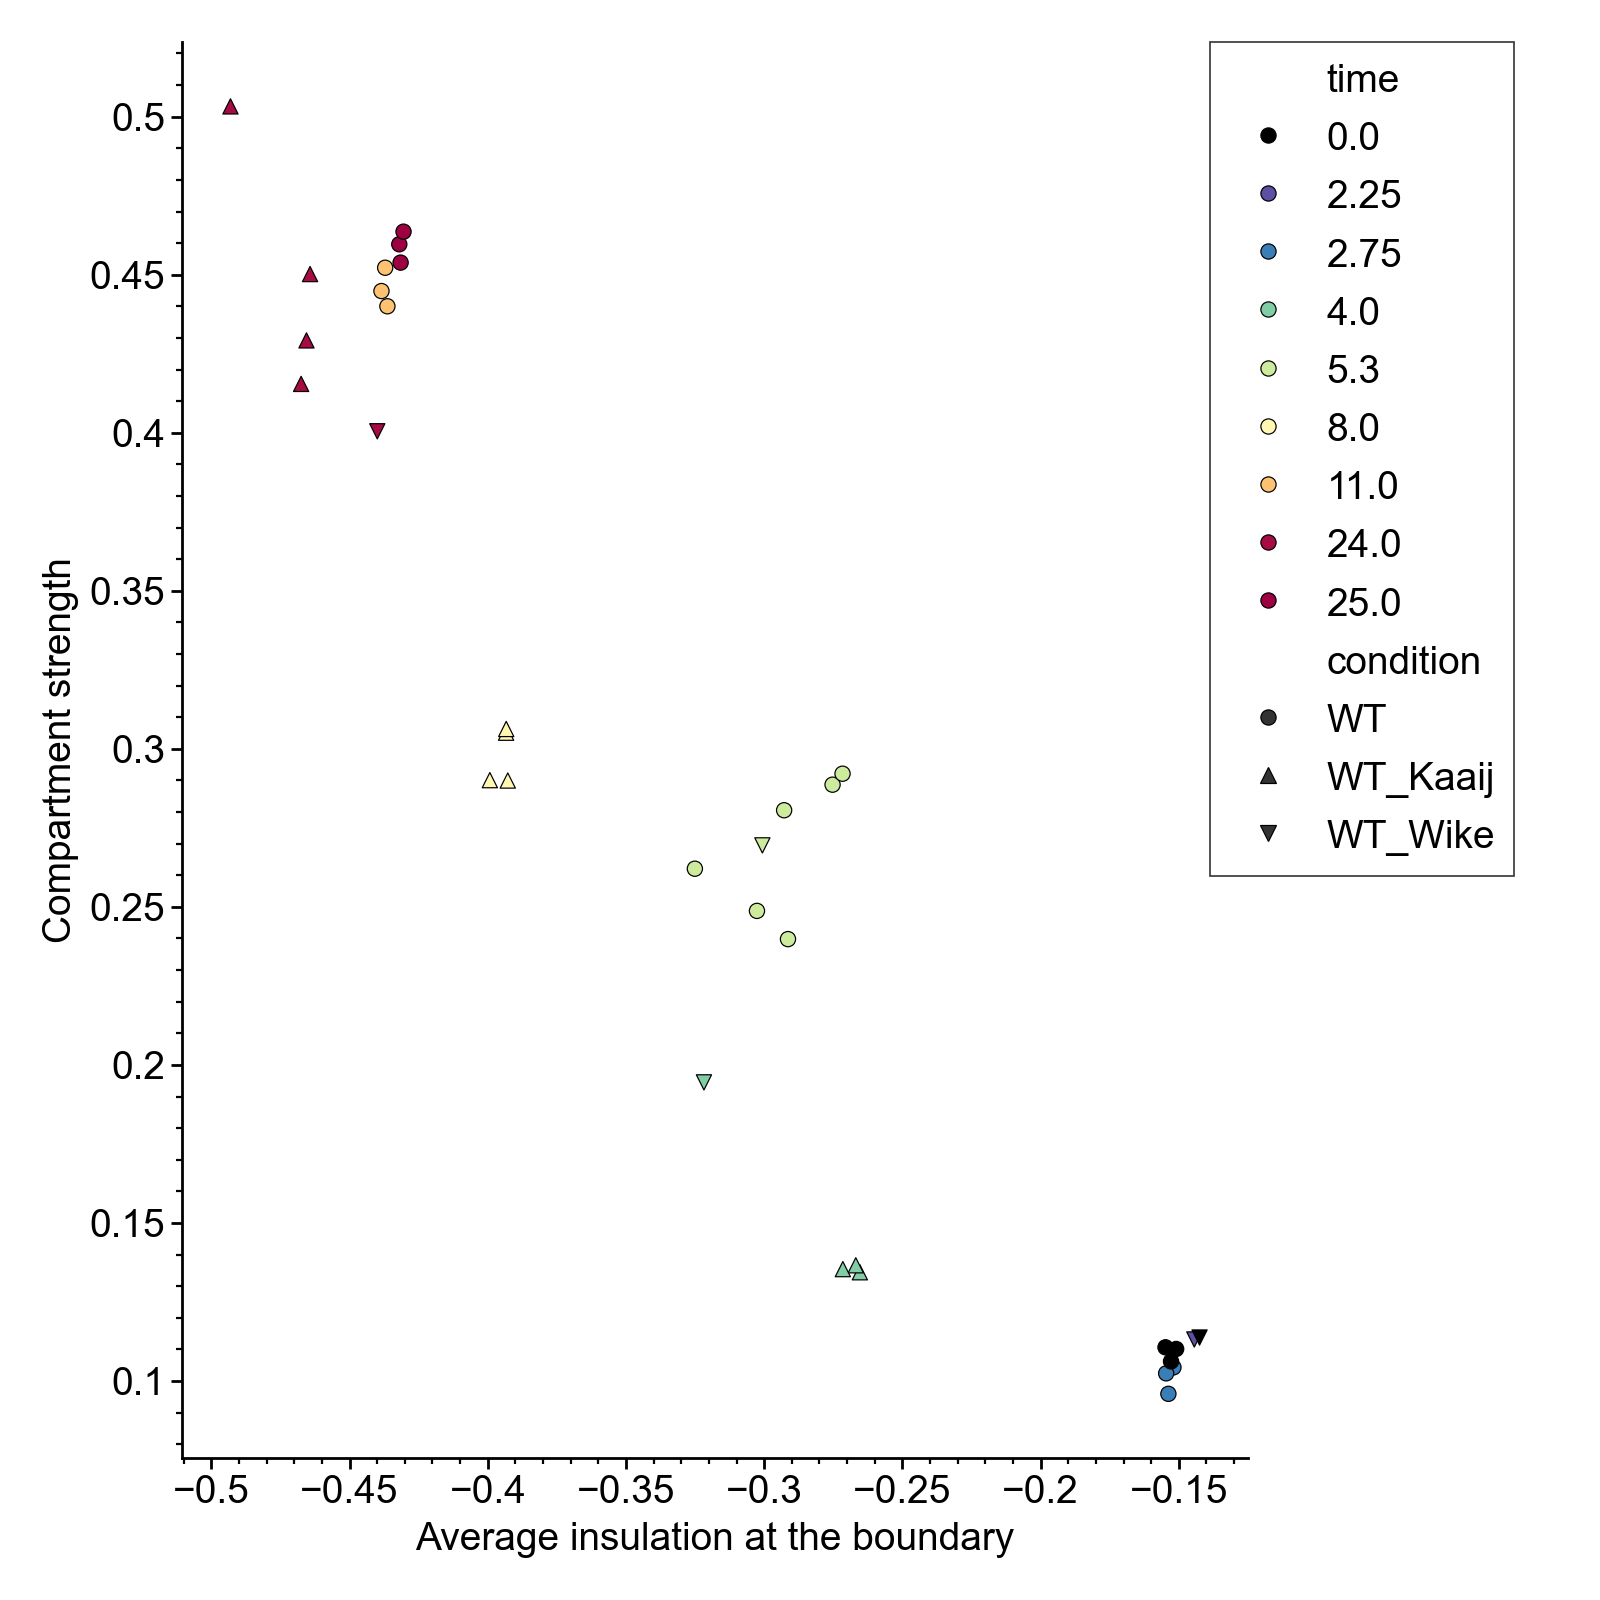

In [26]:
f = plt.figure(figsize=[8, 8])
sns.scatterplot(
    data=df_toplot.query(f"mutant in {list_toplot}"),
    x="insulation",
    y="score",
    hue="time",
    style="condition",
    markers={"mut": "X", "WT": "o", "WT_Wike": "v", "WT_Kaaij": "^", "RT": "*"},
    hue_norm=mpl.colors.LogNorm(),
    palette=sns.color_palette("Spectral_r", n_colors=9, as_cmap=True),
    s=30,
    edgecolor="black",
    alpha=1.0,
    legend="full",
)

plt.legend(bbox_to_anchor=(1.25, 1))


plt.tight_layout()
plt.xlabel("Average insulation at the boundary")
plt.ylabel("Compartment strength")

f.axes[0].yaxis.tick_left()
f.axes[0].xaxis.tick_bottom()

sns.despine()

if do_save:
    prefix = f"{output_folder}/Fig1F-bottom.IS-E1"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [27]:
# Save the data:
df_output = df_toplot.query(f"mutant in {list_toplot}").loc[
    :, ["label", "condition", "mutant", "time", "insulation", "score"]
]

if do_save:
    prefix = f"{output_folder}/Fig1F-bottom.IS-E1"
    df_output.to_csv(f"{prefix}.source.csv")

In [28]:
section_flush()

✅ Section cleaned


### + Insulation profiles (SFig. 1c)

In [5]:
section_start()

✅ Section started


In [6]:
labels = [
    "Wild-Type_2.75",
    "sperm",
    "WT",
    "Wild-Type_11",
    "Wild-Type_25",
]

df = pd.DataFrame()

df = (
    df_insulation.loc[(df_insulation["is_selected_boundary_Wild-Type_25"] == True)]
    .loc[:, [f"log2IS_Wild-Type_2.75"]]
    .melt()
)

for label in labels[1:]:
    boundaries = (
        df_insulation.loc[(df_insulation[f"is_selected_boundary_Wild-Type_25"] == True)]
        .loc[:, [f"log2IS_{label}"]]
        .melt()
    )

    df = pd.concat([df, boundaries])

df = (
    df.set_index("variable")
    .loc[[f"log2IS_{label}" for label in labels], :]
    .reset_index()
    .rename({"variable": "label"}, axis=1)
)

In [7]:
cols_order = [
    "log2IS_sperm",
    "log2IS_Wild-Type_2.75",
    "log2IS_WT",
    "log2IS_Wild-Type_11",
    "log2IS_Wild-Type_25",
]
colors_order = [
    color_sperm,
    color_2_75,
    color_5_3,
    color_11,
    color_25,
]

Logging: group1, group2, p-value, alternative type, p_value less, p_value greater
log2IS_sperm log2IS_Wild-Type_2.75 0.23247711931547588 min 0.767606738403791 0.23247711931547588
log2IS_sperm log2IS_WT 4.174690509216132e-25 min 1.0 4.174690509216132e-25
log2IS_sperm log2IS_Wild-Type_11 5.339825352489577e-65 min 1.0 5.339825352489577e-65
log2IS_sperm log2IS_Wild-Type_25 2.5419349743442626e-68 min 1.0 2.5419349743442626e-68
log2IS_Wild-Type_2.75 log2IS_WT 1.647223532753291e-26 min 1.0 1.647223532753291e-26
log2IS_Wild-Type_2.75 log2IS_Wild-Type_11 3.801303669336522e-67 min 1.0 3.801303669336522e-67
log2IS_Wild-Type_2.75 log2IS_Wild-Type_25 4.160897782182494e-70 min 1.0 4.160897782182494e-70
log2IS_WT log2IS_Wild-Type_11 2.72080440149387e-22 min 1.0 2.72080440149387e-22
log2IS_WT log2IS_Wild-Type_25 3.582843326241255e-24 min 1.0 3.582843326241255e-24
log2IS_Wild-Type_11 log2IS_Wild-Type_25 0.44220782011855564 min 0.5579005558236618 0.44220782011855564
Summary: label value {('log2IS_sperm'

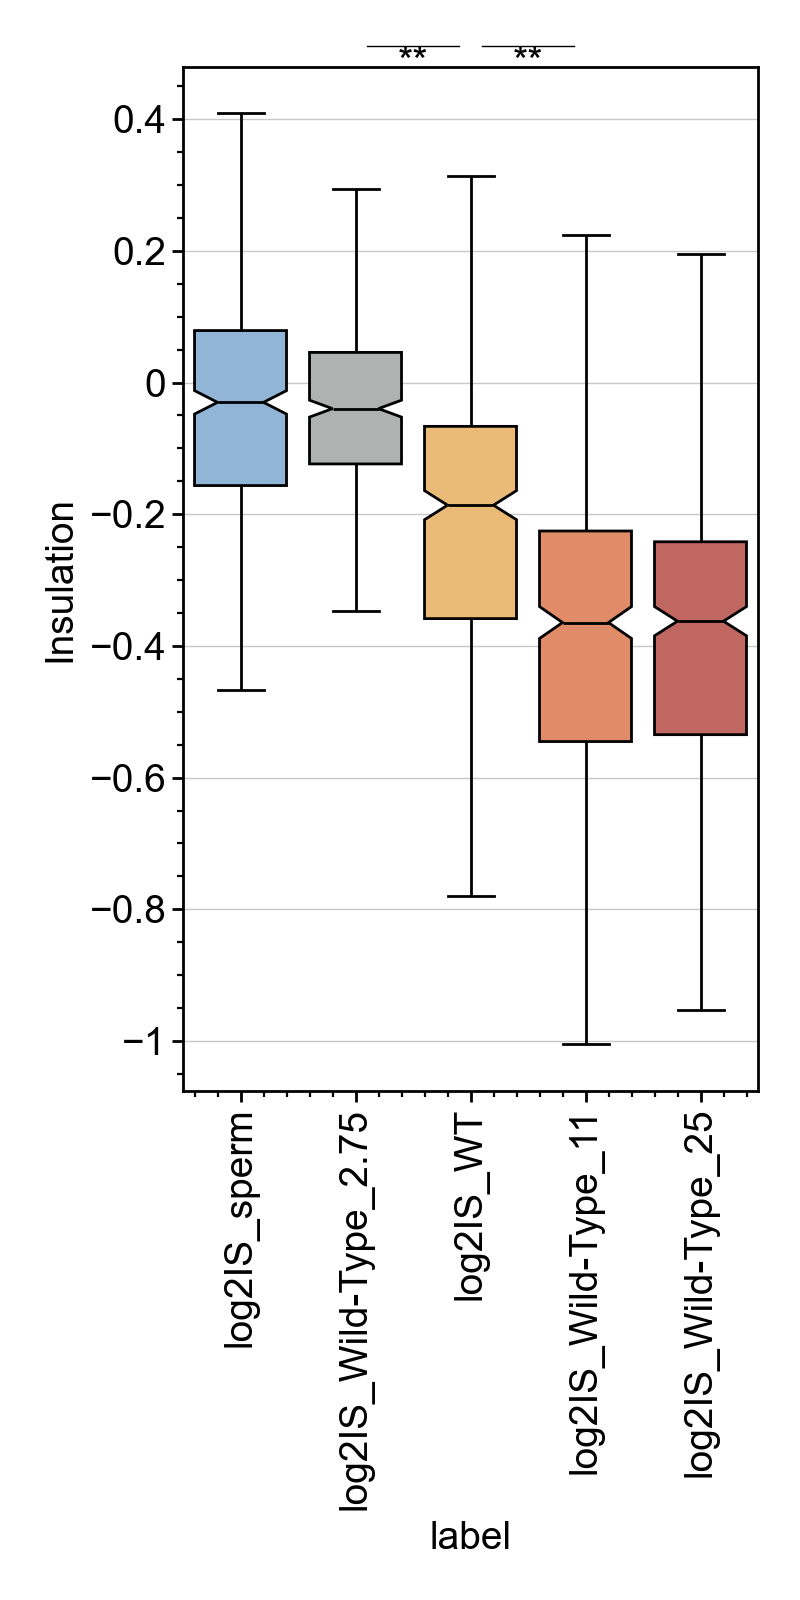

In [12]:
f, ax = plt.subplots(1, 1, figsize=[4, 8])

sns.boxplot(
    data=df,
    x="label",
    y="value",
    order=cols_order,
    notch=True,
    width=0.8,
    palette=colors_order,
    linewidth=1,
    linecolor="k",
    fliersize=3,
    showcaps=True,
    showfliers=False,
    ax=ax,
)

annotate_boxplot(
    data=df,
    x="label",
    y="value",
    order=cols_order,
    ax=ax,
    shift_asterisks=False,
    max_level=1,
    max_asterisks=2,
    plot_hlines=True,
    alt="min",
)

ax.grid(True, axis="y", color="gray", linewidth=0.5, alpha=0.5)

ax.set_xticklabels(cols_order, rotation=90)

ax.set_ylabel("Insulation")
f.tight_layout()

if do_save:
    prefix = f"{output_folder}/SFig1C.insulation"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [33]:
if do_save:
    df_output = df.groupby("label")["value"].describe()
    prefix = f"{output_folder}/SFig1C.insulation"
    df_output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [13]:
section_flush()

✅ Section cleaned


### + Rabl configuration (SFig. 1a,c)

In [14]:
section_start()

✅ Section started


In [15]:
def get_centromeric_score(mtx, offset):
    new_size = mtx.shape[0]
    fragment = mtx[
        new_size - offset : new_size + offset, new_size - offset : new_size + offset
    ]
    return np.nanmedian(fragment)


def get_telomeric_score(mtx, offset):
    new_size = mtx.shape[0]
    fragments = [
        mtx[0:offset, 0:offset],
        mtx[0:offset, new_size - offset : new_size],
        mtx[new_size - offset : new_size, new_size - offset : new_size],
        mtx[new_size - offset : new_size, 0:offset],
    ]
    return np.nanmedian(fragments)

In [16]:
import pickle
from cooltools.lib.numutils import iterative_correction_asymmetric
from scipy.ndimage.filters import gaussian_filter

In [17]:
maps = pickle.load(
    open(
        "/home/agalicina/DANIO/HIC/WD_2021_paper/04_rabl/results/maps_interchr_250Kb_to200.pickle",
        "rb",
    )
)
df_scores = pd.read_csv(
    "/home/agalicina/DANIO/HIC/WD_2021_paper/04_rabl/results/Rabl_scores.250Kb_to200.csv",
    index_col=0,
)

In [18]:
df_scores = df_scores.query('mode!="all"')

In [19]:
cols_order = [
    "sperm",
    "Wild-Type_2.75",
    "WT",
    "Wild-Type_11",
    "Wild-Type_25",
]
colors_order = [
    color_sperm,
    color_2_75,
    color_5_3,
    color_11,
    color_25,
]

Logging: group1, group2, p-value, alternative type, p_value less, p_value greater
sperm Wild-Type_2.75 0.23665125121717617 min 0.7634940267302701 0.23665125121717617
sperm WT 5.91925688004008e-10 min 5.91925688004008e-10 0.9999999994098112
sperm Wild-Type_11 4.04437141747668e-10 min 4.04437141747668e-10 0.9999999995967609
sperm Wild-Type_25 5.5370589476723964e-30 min 1.0 5.5370589476723964e-30
Wild-Type_2.75 WT 2.1588279776061965e-10 min 2.1588279776061965e-10 0.9999999997847665
Wild-Type_2.75 Wild-Type_11 1.5251717896040095e-09 min 1.5251717896040095e-09 0.9999999984791963
Wild-Type_2.75 Wild-Type_25 4.61554498948214e-28 min 1.0 4.61554498948214e-28
WT Wild-Type_11 0.023306985530712036 min 0.023306985530712036 0.976718955938816
WT Wild-Type_25 1.0719214512182831e-39 min 1.0 1.0719214512182831e-39
Wild-Type_11 Wild-Type_25 2.9676351346022155e-26 min 1.0 2.9676351346022155e-26
Summary: label score_centr {('sperm', 'Wild-Type_2.75'): np.float64(0.23665125121717617), ('sperm', 'WT'): np.f

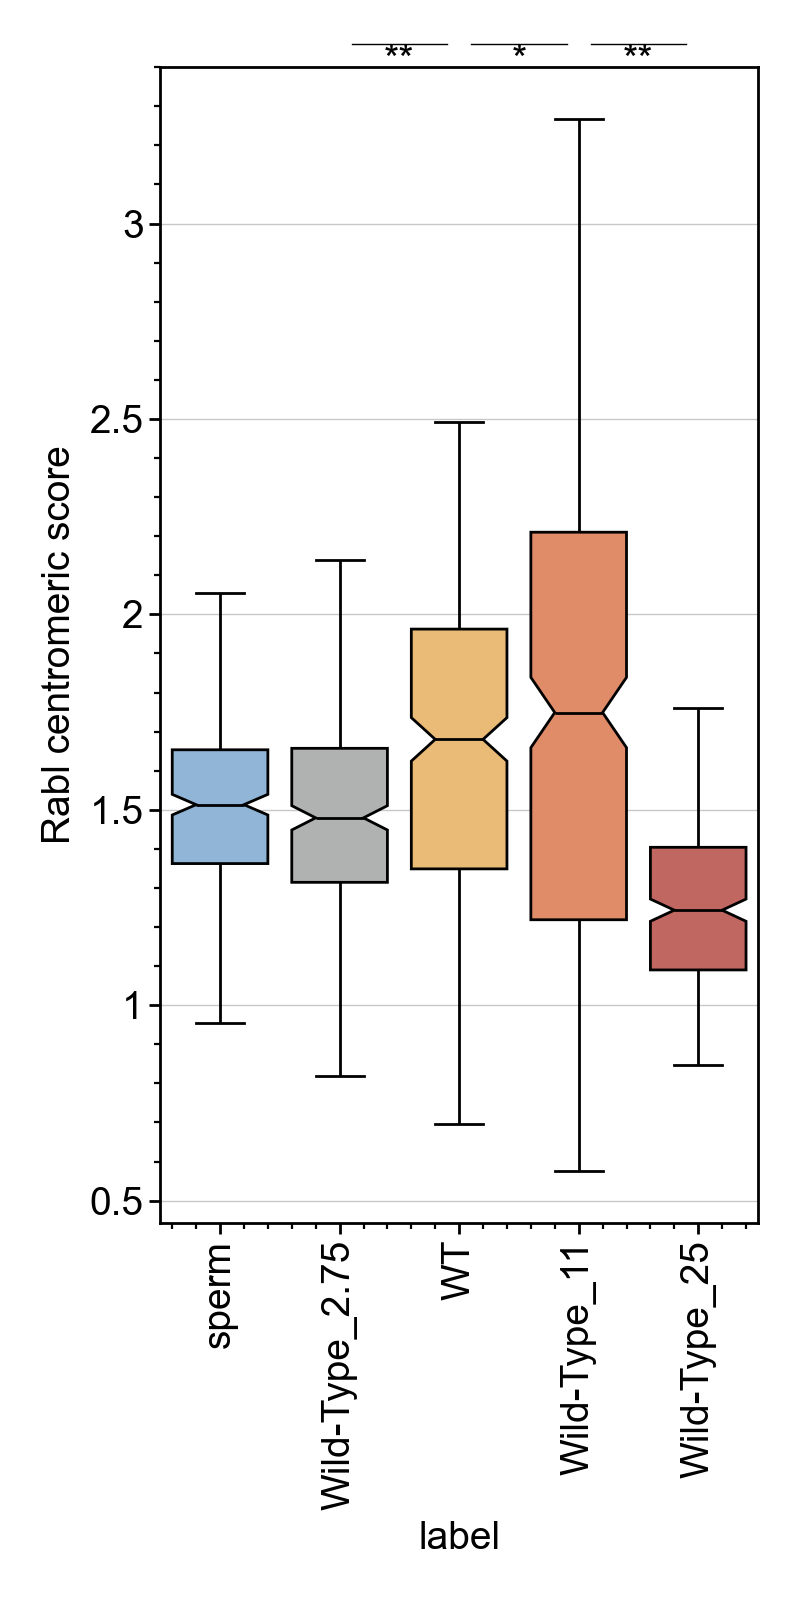

In [20]:
f, ax = plt.subplots(1, 1, figsize=[4, 8])

sns.boxplot(
    data=df_scores,
    x="label",
    y="score_centr",
    order=cols_order,
    notch=True,
    width=0.8,
    palette=colors_order,
    linewidth=1,
    linecolor="k",
    fliersize=3,
    showcaps=True,
    showfliers=False,
    ax=ax,
)

annotate_boxplot(
    data=df_scores,
    x="label",
    y="score_centr",
    order=cols_order,
    ax=ax,
    shift_asterisks=False,
    max_level=1,
    max_asterisks=2,
    plot_hlines=True,
    alt="min",
)

ax.grid(True, axis="y", color="gray", linewidth=0.5, alpha=0.5)

ax.set_xticklabels(cols_order, rotation=90)

ax.set_ylabel("Rabl centromeric score")
f.tight_layout()

if do_save:
    prefix = f"{output_folder}/SFig1C.rabl-centromeric"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [42]:
if do_save:
    df_output = df_scores.groupby("label")["score_centr"].describe()
    prefix = f"{output_folder}/SFig1C.rabl-centromeric"
    df_output.loc[cols_order, :].to_csv(f"{prefix}.source.tsv", sep="\t")

#### + Average Rabl plots (SFig. 1A)

In [43]:
PATH = "/home/agalicina/DANIO/HIC/data_danrer11/distiller/results_danrer11/"

clr_files = glob.glob(
    f"{PATH}/coolers_library_group/*danrer11-reduced.mapq_30.1000.mcool"
) + glob.glob(f"{PATH}/coolers_library/*danrer11-reduced.mapq_30.1000.mcool")

clr_prefixes = list(
    map(lambda x: x.split(".danrer11-reduced")[0].split("/")[-1], clr_files)
)

In [44]:
labels_toplot = [
    "sperm",
    "Wild-Type_2.75",
    "WT",
    "Wild-Type_11",
    "Wild-Type_25",
]

In [45]:
offset = 20
prefix = f"{output_folder}/SFig1A.rabl"

df_scores = {"label": [], "score_centr": [], "score_telo": [], "mode": []}

for label in (pbar := tqdm.tqdm(labels_toplot)):

    mtx = np.log2(np.nanmean(maps[label], axis=0) / np.nanmean(maps[label]))

    pbar.set_description(f"Plotting... {label}")

    mtx[np.isinf(mtx)] = np.min(mtx[np.isfinite(mtx)])
    score_cent = get_centromeric_score(mtx, 10)
    score_telo = get_telomeric_score(mtx, 10)
    scores_cent = [get_centromeric_score(x, 10) for x in maps[label]]
    scores_telo = [get_telomeric_score(x, 10) for x in maps[label]]

    plt.figure(figsize=[5, 5])
    sns.heatmap(
        mtx, square=True, cmap="RdBu_r", center=0, vmin=-1.5, vmax=1.5, cbar=False
    )
    plt.title(f"{label}")
    plt.xticks([0, 100, 200], ["start", "cent", "end"], rotation=0)
    plt.text(100, 25, f"{score_telo:.2f}")
    plt.text(100, 75, f"{score_cent:.2f}")
    plt.yticks([0, 100, 200], ["", "", ""])

    if do_save:
        plt.savefig(f"{prefix}.nocbar.{label}.pdf")
        plt.savefig(f"{prefix}.nocbar.{label}.png")
        plt.close()

    # plt.figure(figsize=[5, 5])
    # sns.heatmap(
    #     mtx, square=True, cmap="RdBu_r", center=0, vmin=-1.5, vmax=1.5, cbar=False
    # )
    # plt.xticks([0, 100, 200], ["start", "cent", "end"], rotation=0)
    # plt.yticks([0, 100, 200], ["", "", ""])

    # if do_save:
    #     plt.savefig(f"{prefix}.notitles.{label}.pdf")
    #     plt.savefig(f"{prefix}.notitles.{label}.png")
    #     plt.close()

    # plt.figure(figsize=[5, 5])
    # sns.heatmap(
    #     mtx, square=True, cmap="RdBu_r", center=0, vmin=-1.5, vmax=1.5, cbar=True
    # )
    # plt.title(f"{label}")
    # plt.xticks([0, 100, 200], ["start", "cent", "end"], rotation=0)
    # plt.text(100, 25, f"{score_telo:.2f}")
    # plt.text(100, 75, f"{score_cent:.2f}")
    # plt.yticks([0, 100, 200], ["", "", ""])

    # if do_save:
    #     plt.savefig(f"{prefix}.cbar.{label}.pdf")
    #     plt.savefig(f"{prefix}.cbar.{label}.png")
    #     plt.close()

    df_scores["label"].append(label)
    df_scores["score_centr"].append(score_cent)
    df_scores["score_telo"].append(score_telo)
    df_scores["mode"].append("all")

    df_scores["label"] += [label for x in scores_telo]
    df_scores["score_centr"] += scores_cent
    df_scores["score_telo"] += scores_telo
    df_scores["mode"] += ["bychr" for x in scores_telo]

df_scores = pd.DataFrame(df_scores)

Plotting... Wild-Type_25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


In [46]:
labels = [
    "sperm",
    "Wild-Type_2.75",
    "WT",
    "Wild-Type_11",
    "Wild-Type_25",
]
maps = [f"{prefix}.nocbar.{label}.png" for label in labels]

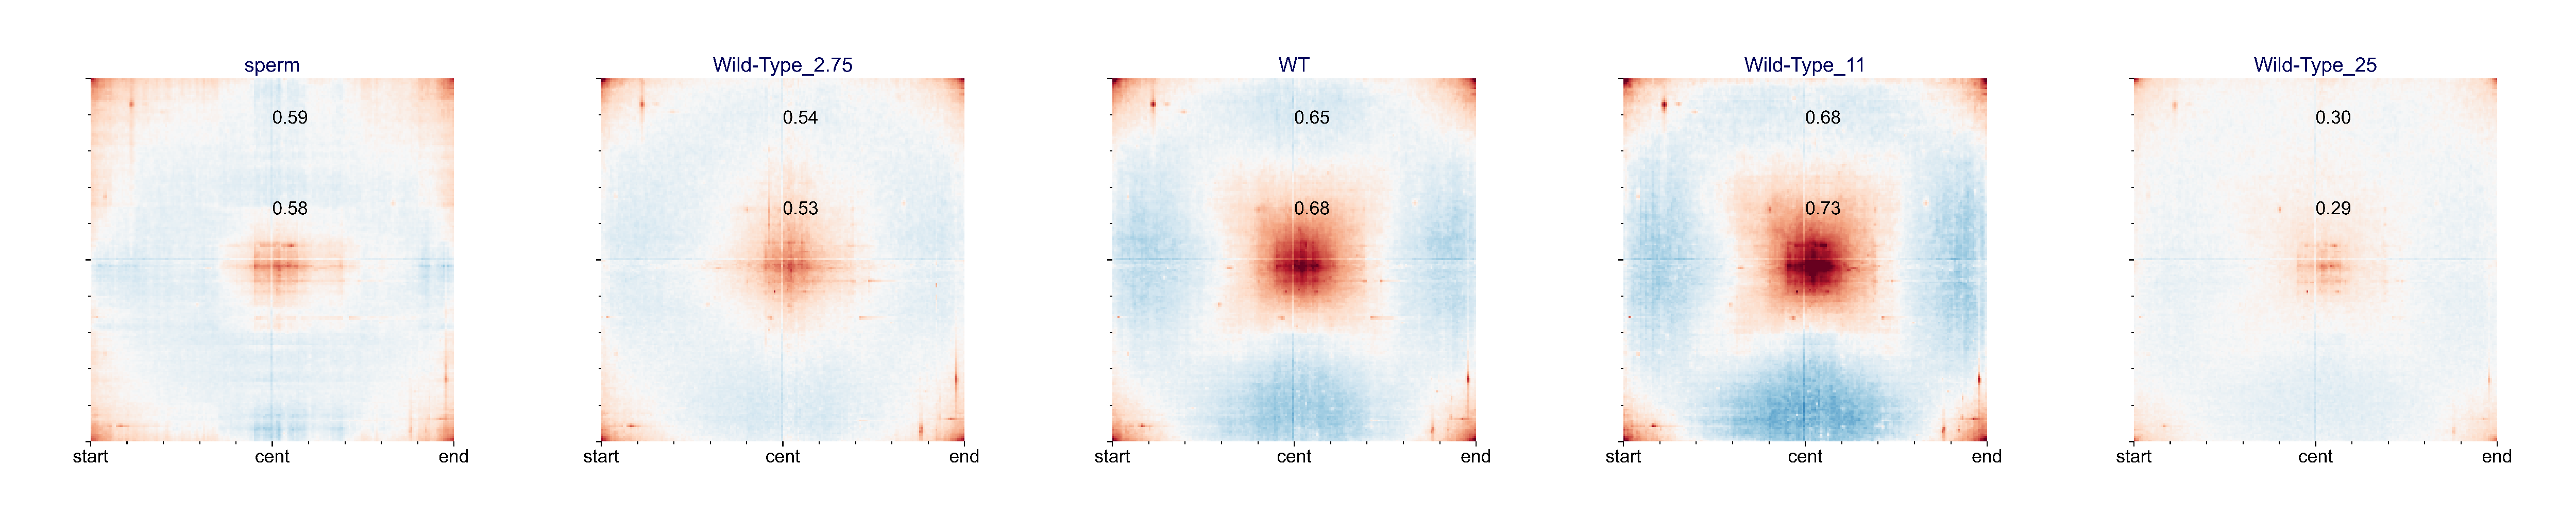

In [47]:
fig, axarr = plt.subplots(1, 5, figsize=(25, 5))
curr_row = 0
for i, f in enumerate(maps):

    a = plt.imread(f)

    # find the column by taking the current index modulo 3
    col = i
    # plot on relevant subplot
    axarr[col].imshow(a)
    axarr[col].axis("off")

fig.tight_layout()

In [21]:
section_flush()

✅ Section cleaned


### + Compartmental score and saddle plots (SFig. 1b,c)

In [22]:
section_start()

✅ Section started


In [23]:
from multiprocess import Pool
import cooltools.api.saddle as saddle
from cooltools.api import expected
from cooltools.api.expected import expected_cis
from cooltools.api.saddle import saddle, saddleplot, _make_cis_obsexp_fetcher

In [24]:
def plot_saddle(mtx, score, group_bounds, label, cbar=True, add_score=True):

    fig = plt.figure(figsize=[4, 4], constrained_layout=True)
    spec = fig.add_gridspec(
        ncols=2, nrows=2, width_ratios=[10, 0.5], height_ratios=[2, 10]
    )
    spec.update(wspace=0.00, hspace=0.005)

    ax_barplot = fig.add_subplot(spec[0, 0])
    ax_barplot.bar(np.arange(len(group_bounds)) + 0.5, group_bounds)
    ax_barplot.get_xaxis().set_visible(False)
    ax_barplot.set_frame_on(False)
    ax_barplot.set_yticks([])

    ax_heatmap = fig.add_subplot(spec[1, 0], sharex=ax_barplot)
    hm = ax_heatmap.imshow(mtx, cmap="coolwarm", vmin=-1, vmax=1)
    ax_heatmap.plot([-0.5, len(mtx) - 0.5], [th, th], "--", c="black", lw=1, alpha=0.5)
    ax_heatmap.plot([th, th], [-0.5, len(mtx) - 0.5], "--", c="black", lw=1, alpha=0.5)
    ax_heatmap.get_xaxis().set_visible(False)
    ax_heatmap.get_yaxis().set_visible(False)
    ax_heatmap.set_frame_on(False)
    ax_heatmap.set_xlim([0 - 0.5, len(mtx)])
    # ax_heatmap.set_xlim([0, len(mtx)])

    if add_score:
        plt.text(th + 0.5, th - 0.5, f"{score:.2f}")

    if cbar:
        ax_colorbar = fig.add_subplot(spec[1, 1])
        plt.colorbar(cax=ax_colorbar, mappable=hm)
        ax_colorbar.set_ylabel("log2(obs/exp)")

    fig.suptitle(f"{label}")

    # fig.tight_layout()

#### + Load the data and calculate saddle plots

In [25]:
Q_LO = 0.025  # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975  # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 10  # divide remaining 95% of the genome into N equisized groups, 95/N % each
q_edges = np.linspace(Q_LO, Q_HI, N_GROUPS + 1)

In [26]:
binsize_comp = 100_000
nproc = 14

In [27]:
labels = [
    "sperm",
    "Wild-Type_2.75",
    "WT",
    "Wild-Type_5.3",
    "Wild-Type_11",
    "Wild-Type_25",
]

In [28]:
lst_eigs = []

for label in labels:
    print(label)

    cis_df = pd.read_csv(
        f"/home/agalicina/DANIO/HIC/WD_2021_paper/03_compartment/results/cis-eigs.{label}.{binsize_comp}.RT-phased.csv",
        index_col=0,
    )
    cis_df = cis_df.drop("Unnamed: 0", axis=1)
    cols_todrop = cis_df.columns[3:]
    cols_todrop = [x for x in cols_todrop if not "E1" in x]
    cis_df = cis_df.drop(cols_todrop, axis=1)

    lst_eigs.append(cis_df.copy())

cols = ["chrom", "start", "end"]
df_eigs = lst_eigs[0]
for i in range(1, len(lst_eigs)):
    df_eigs = pd.merge(df_eigs, lst_eigs[i], on=cols, how="outer")

df_eigs = df_eigs.reset_index(drop=True)

sperm
Wild-Type_2.75
WT
Wild-Type_5.3
Wild-Type_11
Wild-Type_25


In [29]:
# Create expected table:
expected_dct = {}

for label in labels:
    print(label)

    clr_file = dct_files[label]
    coolpath = f"{clr_file}::/resolutions/{binsize_comp}"
    clr = cooler.Cooler(coolpath)

    exp = expected_cis(
        clr,
        view_df=chromarms,
        smooth=False,
        aggregate_smoothed=False,
        nproc=nproc,
    )

    expected_dct.update({label: exp.copy()})

sperm
Wild-Type_2.75
WT
Wild-Type_5.3
Wild-Type_11
Wild-Type_25


In [30]:
## Plotting whole-genome saddles:
prefix = f"{output_folder}/SFig1B.saddles"

for reference in ["Wild-Type_25"]:  # , "Wild-Type_11", "samestage"]:

    df_saddle = {"label": [], "score": [], "reference": []}
    dct_mtxs = {}
    for label in labels:
        print(label, reference)

        target = reference if not reference == "samestage" else label

        clr_file = dct_files[label]
        coolpath = f"{clr_file}::/resolutions/{binsize_comp}"
        clr = cooler.Cooler(coolpath)
        df_expected = expected_dct[label]

        group_bounds = np.nanpercentile(df_eigs[f"E1_{target}"], 100 * q_edges)
        th = np.where(group_bounds > 0)[0][0]

        digitized, hist = cooltools.digitize(
            track=df_eigs[["chrom", "start", "end", f"E1_{target}"]],
            n_bins=N_GROUPS,
            qrange=[Q_LO, Q_HI],
        )

        S, C = saddle(
            clr=clr,
            expected=df_expected,
            view_df=chromarms,
            track=digitized[["chrom", "start", "end", f"E1_{target}.d"]],
            contact_type="cis",
            n_bins=None,
        )

        mtx = np.log2(S / C)
        AABB = np.nanmean(
            np.concatenate([mtx[0:th, 0:th].flatten(), mtx[th:, th:].flatten()])
        )
        ABBA = np.nanmean(
            np.concatenate([mtx[0:th, th:].flatten(), mtx[th:, 0:th].flatten()])
        )
        score = (AABB) - (ABBA)

        dct_mtxs[label] = [S.copy(), C.copy(), mtx.copy()]

        df_saddle["label"].append(label)
        df_saddle["score"].append(score)
        df_saddle["reference"].append(reference)

        plot_saddle(mtx, score, group_bounds, label, cbar=True, add_score=True)
        if do_save:
            plt.savefig(f"{prefix}.by-{reference}.{label}.{binsize_comp}.pdf")
            plt.savefig(f"{prefix}.by-{reference}.{label}.{binsize_comp}.png")
            plt.close("all")

        plot_saddle(mtx, score, group_bounds, label, cbar=False, add_score=True)
        if do_save:
            plt.savefig(f"{prefix}.by-{reference}.nocbar.{label}.{binsize_comp}.pdf")
            plt.savefig(f"{prefix}.by-{reference}.nocbar.{label}.{binsize_comp}.png")
            plt.close("all")

        plot_saddle(mtx, score, group_bounds, label, cbar=False, add_score=False)
        if do_save:
            plt.savefig(f"{prefix}.by-{reference}.plain.{label}.{binsize_comp}.pdf")
            plt.savefig(f"{prefix}.by-{reference}.plain.{label}.{binsize_comp}.png")
            plt.close("all")

    df_saddle = pd.DataFrame(df_saddle)
    if do_save:
        df_saddle.to_csv(f"{prefix}.source.by-{reference}.{binsize_comp}.csv")

sperm Wild-Type_25
Wild-Type_2.75 Wild-Type_25
WT Wild-Type_25
Wild-Type_5.3 Wild-Type_25
Wild-Type_11 Wild-Type_25
Wild-Type_25 Wild-Type_25


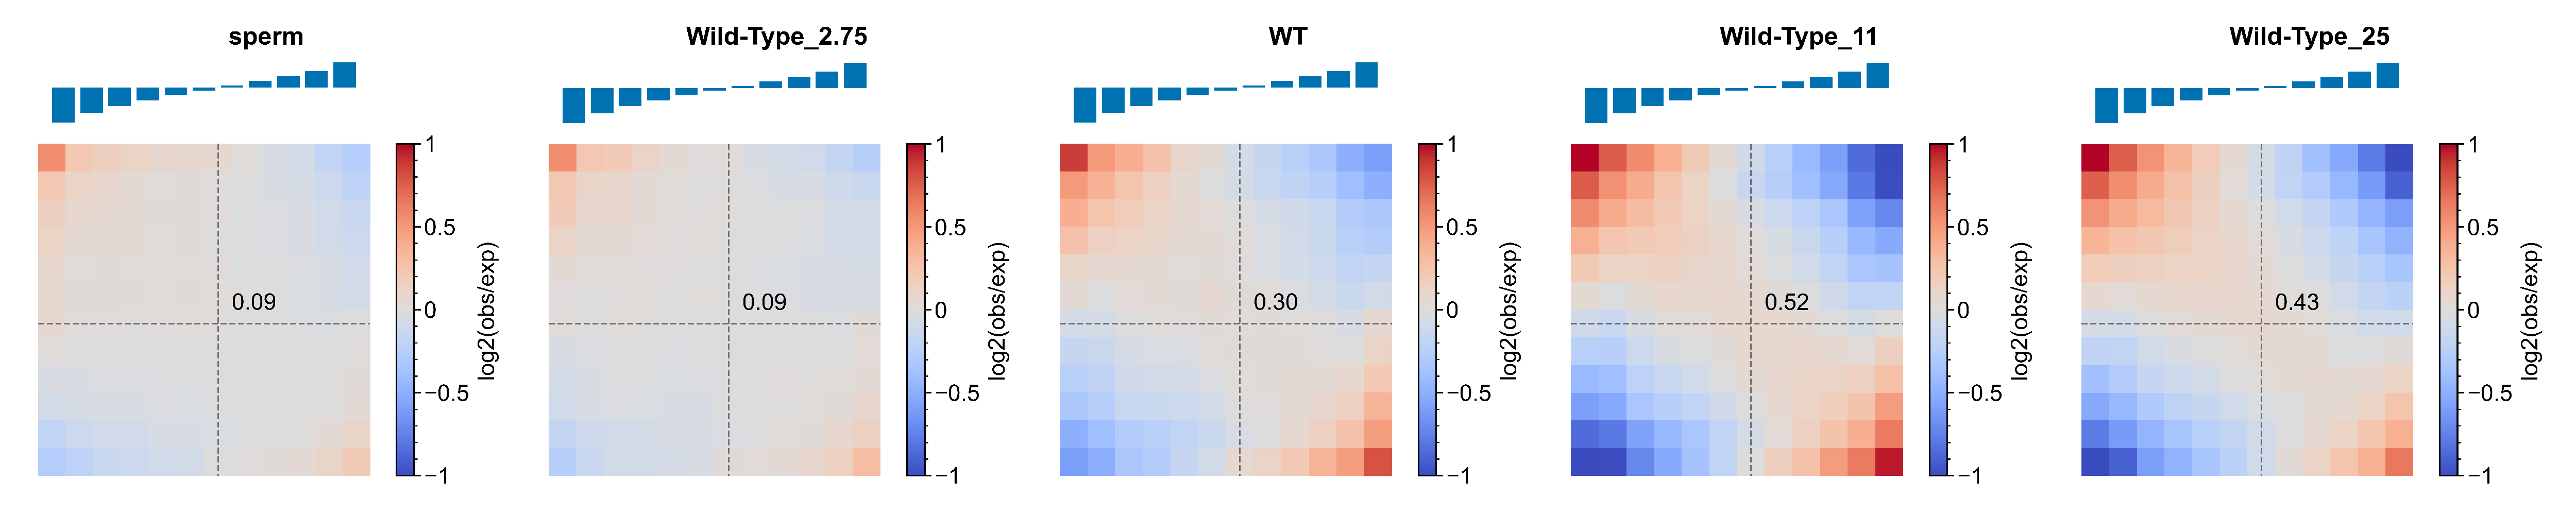

In [31]:
# Collect multiple figures into a representative one:

labels = [
    "sperm",
    "Wild-Type_2.75",
    "WT",
    "Wild-Type_11",
    "Wild-Type_25",
]
reference = "Wild-Type_25"
maps = [f"{prefix}.by-{reference}.{label}.{binsize_comp}.png" for label in labels]


fig, axarr = plt.subplots(1, 5, figsize=(25, 5))
curr_row = 0
for i, f in enumerate(maps):

    a = plt.imread(f)

    # find the column by taking the current index modulo 3
    col = i
    # plot on relevant subplot
    axarr[col].imshow(a)
    axarr[col].axis("off")

fig.tight_layout()

#### Per chromosome saddle plot strength

In [32]:
labels = [
    "sperm",
    "Wild-Type_2.75",
    "WT",
    "Wild-Type_11",
    "Wild-Type_25",
]

In [33]:
prefix = f"{output_folder}/SFig1B.saddles.by-chromosome"
for reference in ["Wild-Type_25"]:  # , "Wild-Type_11", "samestage"]:

    df_saddle = {"label": [], "score": [], "reference": [], "region": []}

    for label in labels:
        print(label, reference)

        target = reference if not reference == "samestage" else label

        clr_file = dct_files[label]
        coolpath = f"{clr_file}::/resolutions/{binsize_comp}"
        clr = cooler.Cooler(coolpath)
        df_expected = expected_dct[label]

        for i, region in chromarms.iterrows():
            chrom = region["chrom"]
            if chrom == "chrM":
                continue

            df_eigs_chrom = bioframe.select(df_eigs, region)
            viewframe_chrom = bioframe.make_viewframe([region]).reset_index(drop=True)
            expected_chrom = df_expected.query(f'region1=="{region['name']}"')

            group_bounds = np.nanpercentile(
                df_eigs_chrom[f"E1_{target}"], 100 * q_edges
            )
            th = np.where(group_bounds > 0)[0][0]

            digitized, hist = cooltools.digitize(
                track=df_eigs_chrom[["chrom", "start", "end", f"E1_{target}"]],
                n_bins=N_GROUPS,
                qrange=[Q_LO, Q_HI],
            )

            S, C = saddle(
                clr=clr,
                expected=expected_chrom,
                view_df=viewframe_chrom,
                track=digitized[["chrom", "start", "end", f"E1_{target}.d"]],
                contact_type="cis",
                n_bins=None,
            )

            mtx = np.log2(S / C)
            AABB = np.nanmean(
                np.concatenate([mtx[0:th, 0:th].flatten(), mtx[th:, th:].flatten()])
            )
            ABBA = np.nanmean(
                np.concatenate([mtx[0:th, th:].flatten(), mtx[th:, 0:th].flatten()])
            )
            score = (AABB) - (ABBA)

            dct_mtxs[label] = [S.copy(), C.copy(), mtx.copy()]

            df_saddle["label"].append(label)
            df_saddle["score"].append(score)
            df_saddle["reference"].append(reference)
            df_saddle["region"].append(region)

    df_saddle = pd.DataFrame(df_saddle)
    if do_save:
        df_saddle.to_csv(f"{prefix}.source.by-{reference}.{binsize_comp}.csv")

sperm Wild-Type_25
Wild-Type_2.75 Wild-Type_25
WT Wild-Type_25
Wild-Type_11 Wild-Type_25
Wild-Type_25 Wild-Type_25


In [34]:
cols_order = [
    "sperm",
    "Wild-Type_2.75",
    "WT",
    "Wild-Type_11",
    "Wild-Type_25",
]
colors_order = [
    color_sperm,
    color_2_75,
    color_5_3,
    color_11,
    color_25,
]

Logging: group1, group2, p-value, alternative type, p_value less, p_value greater
sperm Wild-Type_2.75 0.14814701135423736 min 0.8534413153269645 0.14814701135423736
sperm WT 7.2726107832747e-10 min 7.2726107832747e-10 0.9999999993032164
sperm Wild-Type_11 8.20732453010494e-16 min 8.20732453010494e-16 0.9999999999999992
sperm Wild-Type_25 1.6913453278647533e-16 min 1.6913453278647533e-16 0.9999999999999999
Wild-Type_2.75 WT 2.243333307485938e-11 min 2.243333307485938e-11 0.9999999999785846
Wild-Type_2.75 Wild-Type_11 5.037236807539936e-15 min 5.037236807539936e-15 0.9999999999999952
Wild-Type_2.75 Wild-Type_25 4.053755711795249e-15 min 4.053755711795249e-15 0.9999999999999961
WT Wild-Type_11 2.2522611193432128e-10 min 2.2522611193432128e-10 0.9999999997844828
WT Wild-Type_25 1.8060618138673064e-10 min 1.8060618138673064e-10 0.9999999998272194
Wild-Type_11 Wild-Type_25 0.09338971600387758 min 0.9077556360475091 0.09338971600387758
Summary: label score {('sperm', 'Wild-Type_2.75'): np.fl

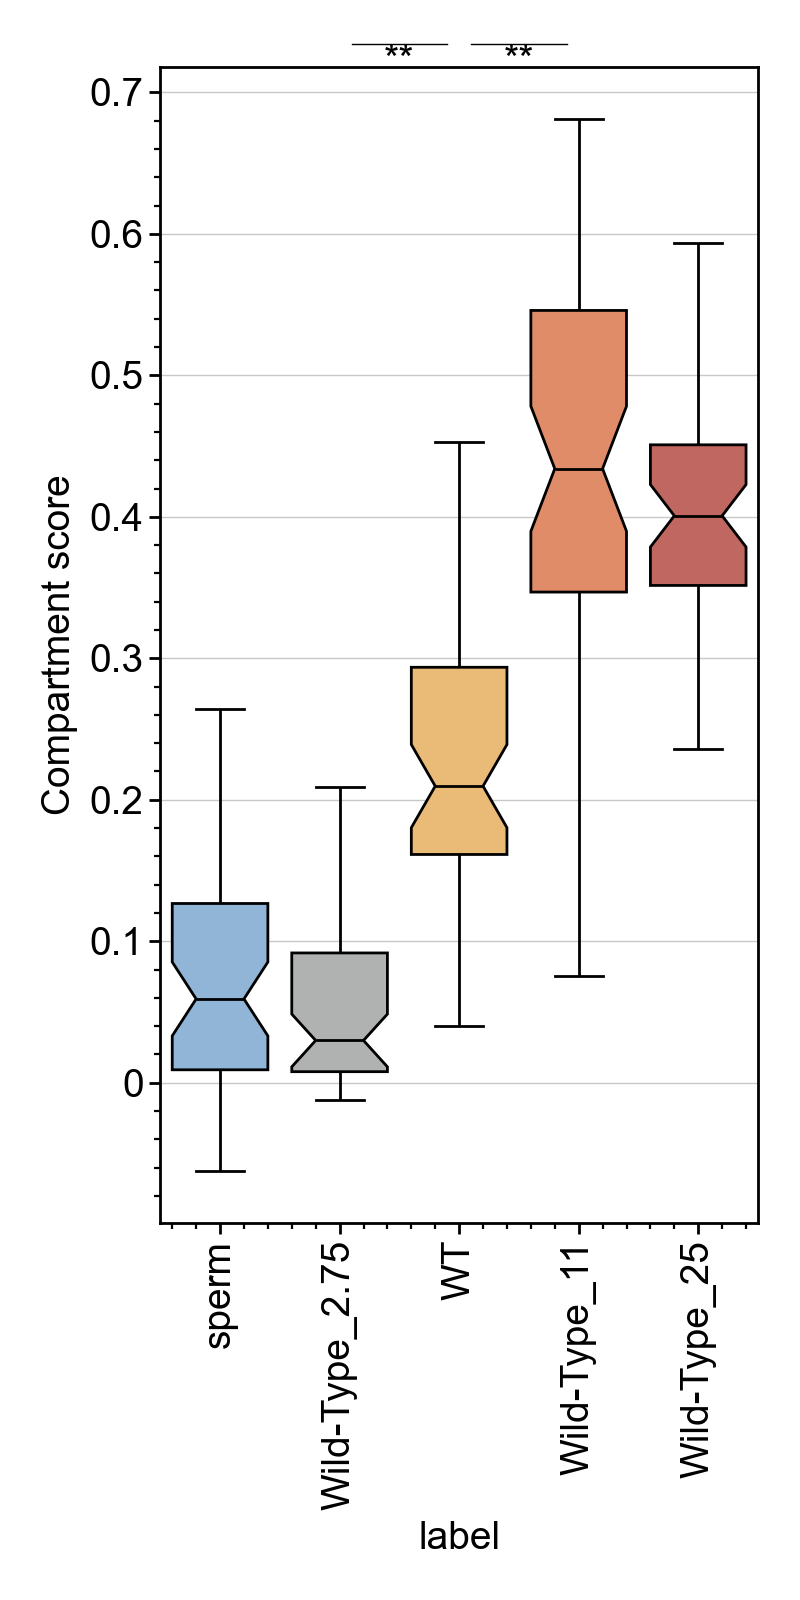

In [35]:
f, ax = plt.subplots(1, 1, figsize=[4, 8])

sns.boxplot(
    data=df_saddle,
    x="label",
    y="score",
    order=cols_order,
    notch=True,
    width=0.8,
    palette=colors_order,
    linewidth=1,
    linecolor="k",
    fliersize=3,
    showcaps=True,
    showfliers=False,
    ax=ax,
)

annotate_boxplot(
    data=df_saddle,
    x="label",
    y="score",
    order=cols_order,
    ax=ax,
    shift_asterisks=False,
    max_level=1,
    max_asterisks=2,
    plot_hlines=True,
    alt="min",
)

ax.grid(True, axis="y", color="gray", linewidth=0.5, alpha=0.5)

ax.set_xticklabels(cols_order, rotation=90)

ax.set_ylabel("Compartment score")
f.tight_layout()

if do_save:
    prefix = f"{output_folder}/SFig1C.compartments"
    f.savefig(f"{prefix}.png")
    f.savefig(f"{prefix}.pdf")

In [36]:
if do_save:
    df_output = df_saddle.groupby("label")["score"].describe()
    prefix = f"{output_folder}/SFig1C.compartments"
    df_output.to_csv(f"{prefix}.source.tsv", sep="\t")

In [37]:
section_flush()

✅ Section cleaned


### + Scaling plots (SFig. 1d)

In [65]:
section_start()

✅ Section started


In [66]:
nproc = 13

In [67]:
genome = "danRer11"
labels = ["sperm", "Wild-Type_2.75", "WT", "Wild-Type_11", "Wild-Type_25"]

In [68]:
# Calculate scalings with smoothing of 0.1 (default) and save, if needed:
cvd_dct = {}
binsize_scalings = 1000

prefix = f"{output_folder}/SFig1D.scalings"
output = []

for label in (pbar := tqdm.tqdm(labels)):
    pbar.set_description(f"Processing: {label}:{binsize_scalings}")
    file = dct_files[label]

    # Load a Hi-C map at a 1kb resolution from a cooler file.
    clr = cooler.Cooler(f"{file}::/resolutions/{binsize_scalings}")

    # cvd == contacts-vs-distance; smoothing by gaussian with sigma 0.05
    cvd_smooth_agg = cooltools.expected_cis(
        clr=clr,
        view_df=chromarms,
        smooth=True,
        smooth_sigma=0.1,
        aggregate_smoothed=True,
        nproc=nproc,
    )

    # cvd_smooth_agg.loc[:, 'dist_bp'] = cvd_smooth_agg['dist']* resolution

    # Remove first two diagonals:
    cvd_smooth_agg.loc[cvd_smooth_agg["dist"] < 2, "balanced.avg.smoothed.agg"] = np.nan

    cvd_dct[label] = cvd_smooth_agg.copy()

    if do_save:
        cvd_merged = cvd_smooth_agg.drop_duplicates(subset=["dist"])[
            ["dist_bp", "balanced.avg.smoothed.agg"]
        ]
        cvd_merged.columns = ["dist_bp", f"P(s) {label}"]
        der = np.gradient(
            np.log(cvd_merged.loc[:, f"P(s) {label}"].values),
            np.log(cvd_merged.loc[:, "dist_bp"].values),
        )
        cvd_merged.loc[:, f"P(s) slope {label}"] = der

        output.append(cvd_merged.copy())

        # cvd_merged.to_csv(
        #     f"{prefix}.{label}.{binsize_scalings}.{genome}.cvd_smooth_agg.csv"
        # )
        # pd.DataFrame(der).to_csv(
        #     f"{prefix}.{label}.{binsize_scalings}.{genome}.der.csv"
        # )

Processing: Wild-Type_25:1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.57s/it]


In [69]:
if do_save:
    prefix = f"{output_folder}/SFig1D.scalings"
    output = pd.concat(output, axis=1)
    output = output.loc[:, ~output.columns.duplicated()]
    output.to_csv(f"{prefix}.source.csv")

In [70]:
cmap = {
    "sperm": color_sperm,
    "Wild-Type_2.75": color_2_75,
    "WT": color_5_3,
    "Wild-Type_11": color_11,
    "Wild-Type_25": color_25,
}

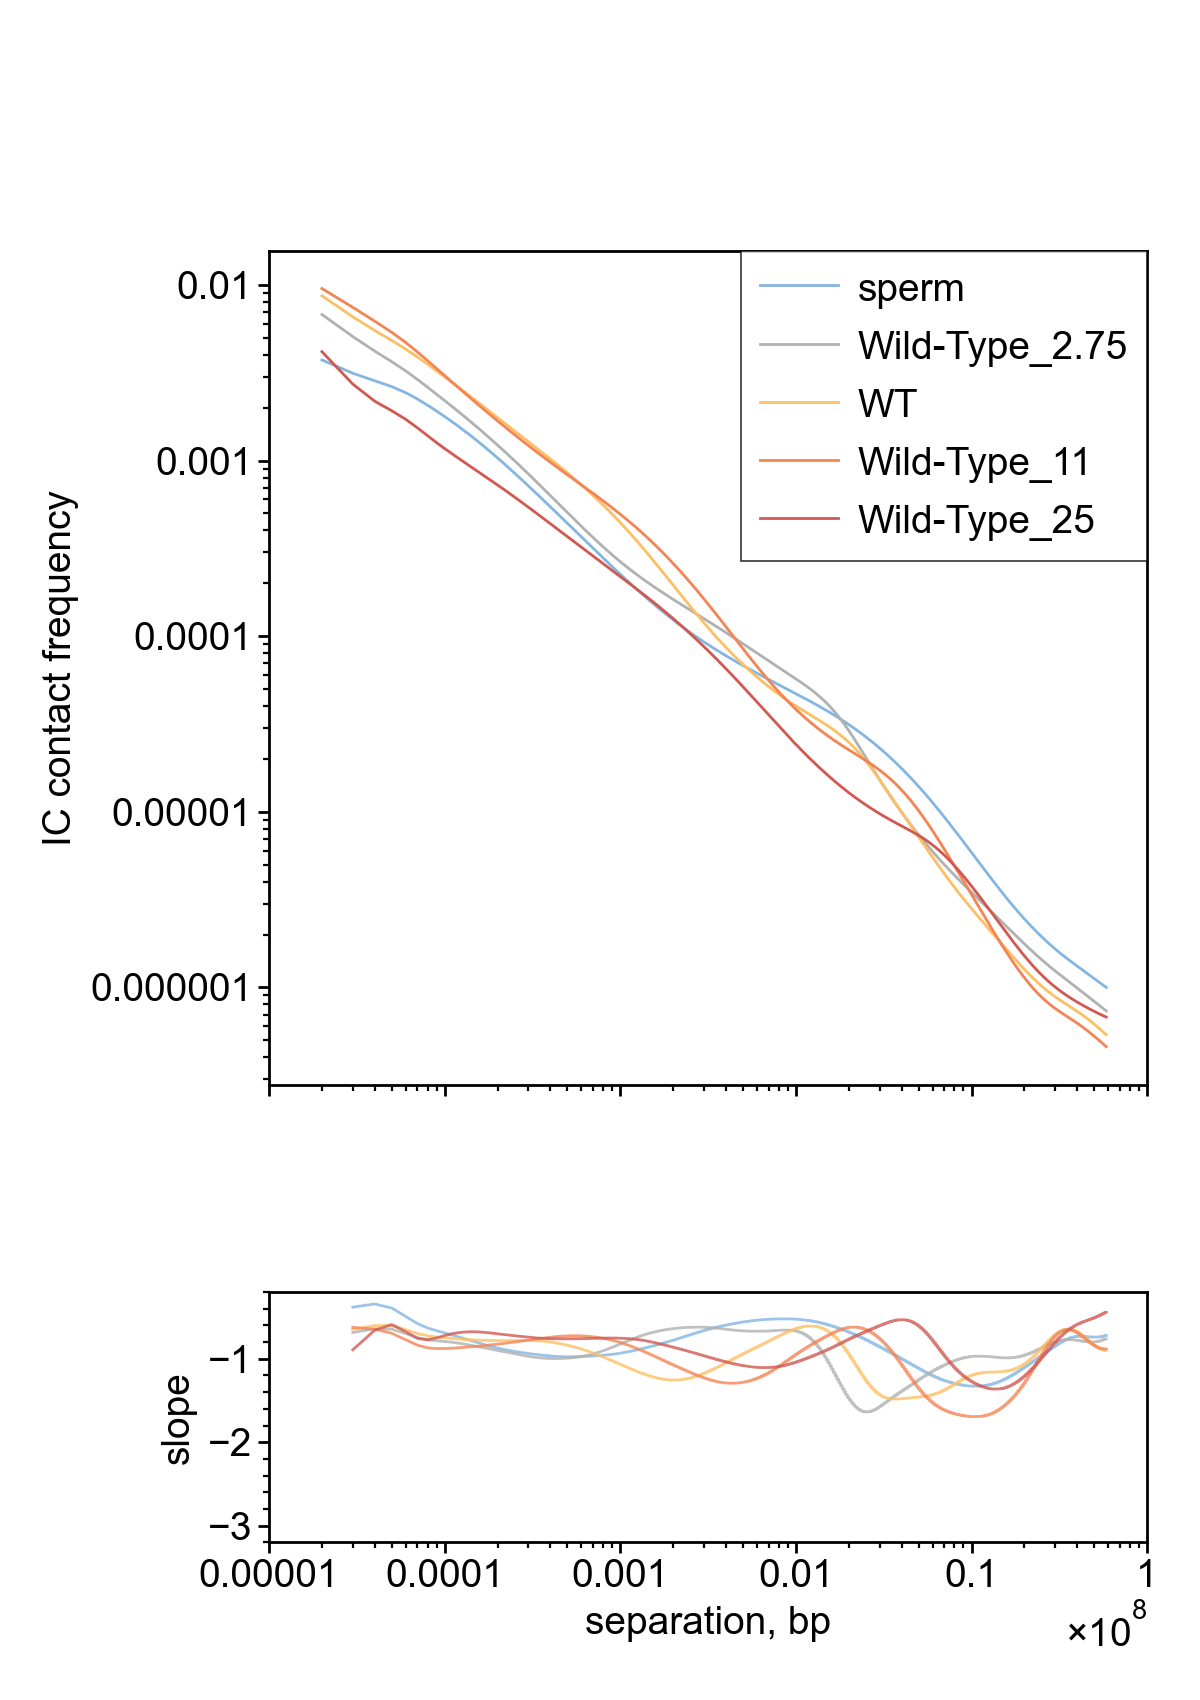

In [71]:
f, axs = plt.subplots(
    figsize=(6, 8.5), nrows=2, gridspec_kw={"height_ratios": [10, 2]}, sharex=True
)

ax = axs[0]
ax.set(ylabel="IC contact frequency", xlim=(1e3, 1e8))
ax.set_aspect(1.0)
ax.grid(lw=0.5)

ax = axs[1]
ax.set(ylim=(-3.2, -0.2), xlabel="separation, bp", ylabel="slope")

ax.grid(lw=0.5)


for i, label in enumerate(labels):
    cvd_smooth_agg = cvd_dct[label]
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=["dist"])[
        ["dist_bp", "balanced.avg.smoothed.agg"]
    ]
    der = np.gradient(
        np.log(cvd_merged["balanced.avg.smoothed.agg"]), np.log(cvd_merged["dist_bp"])
    )

    ax = axs[0]
    ax.loglog(
        cvd_merged["dist_bp"],
        cvd_merged["balanced.avg.smoothed.agg"],
        "-",
        markersize=2,
        linewidth=1,
        label=label,
        color=cmap[label],
    )

    ax = axs[1]
    ax.semilogx(
        cvd_merged["dist_bp"],
        der,
        alpha=0.8,
        linewidth=1,
        label=label,
        color=cmap[label],
    )

axs[0].legend()
f.tight_layout()

if do_save:
    prefix = f"{output_folder}/SFig1D.scalings"
    f.savefig(f"{prefix}.pdf")
    f.savefig(f"{prefix}.png")

In [72]:
section_flush()

✅ Section cleaned
